Map for Run 1:
SFFF
FFFF
FFHF
HFFG
Run 1: Solution found in 0.000477s, Cost: 6, Path: [1, 1, 2, 1, 2, 2], Steps: 61
Map for Run 2:
SFHH
FFFF
FHFH
FFFG
Run 2: Solution found in 0.000392s, Cost: 6, Path: [1, 1, 1, 2, 2, 2], Steps: 57
Map for Run 3:
SFFF
FFFF
FFFF
HFHG
Run 3: Solution found in 0.000438s, Cost: 6, Path: [1, 1, 2, 2, 2, 1], Steps: 61
Map for Run 4:
SHFF
FFFF
FFFH
FHFG
Run 4: Solution found in 0.000362s, Cost: 6, Path: [1, 1, 2, 2, 1, 2], Steps: 53
Map for Run 5:
SFFF
FFFF
FFFF
FFHG
Run 5: Solution found in 0.000478s, Cost: 6, Path: [1, 1, 2, 2, 2, 1], Steps: 61


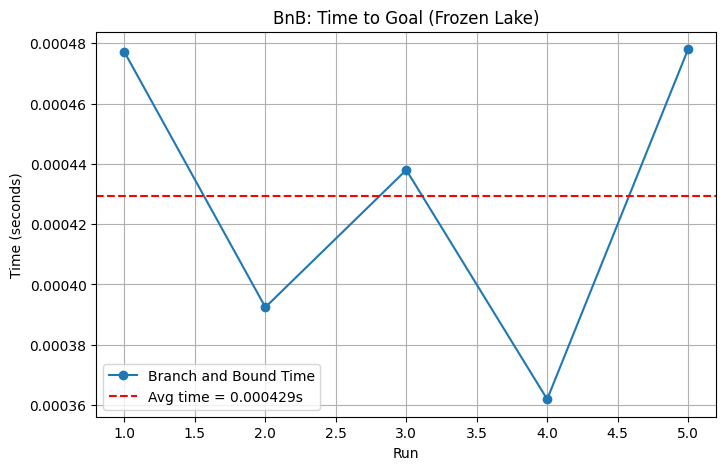

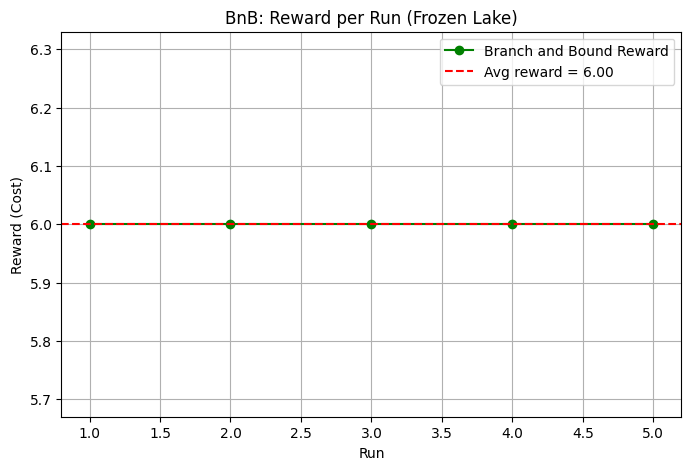

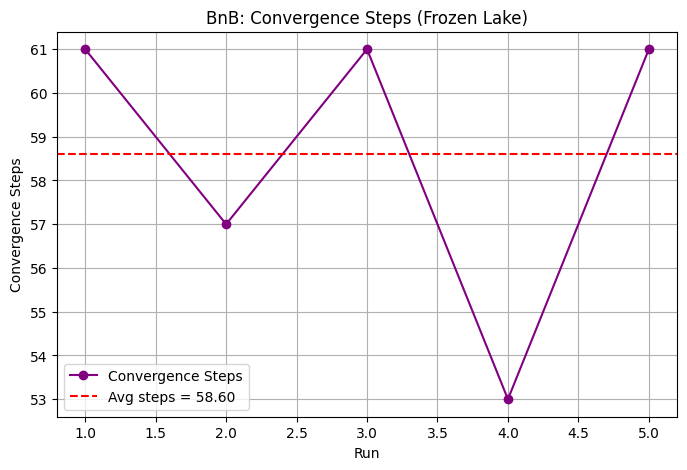


=== Performance Summary ===
Run 1: Time = 0.000477s, Reward = 6, Convergence Steps = 61
Run 2: Time = 0.000392s, Reward = 6, Convergence Steps = 57
Run 3: Time = 0.000438s, Reward = 6, Convergence Steps = 61
Run 4: Time = 0.000362s, Reward = 6, Convergence Steps = 53
Run 5: Time = 0.000478s, Reward = 6, Convergence Steps = 61

Average Time: 0.000429s
Average Reward: 6.00
Average Convergence Steps: 58.60


In [ ]:
import gymnasium as gym
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt
import imageio
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Heuristic function: Manhattan Distance
def heuristic(state, goal):
    x1, y1 = state // 4, state % 4
    x2, y2 = goal // 4, goal % 4
    return abs(x1 - x2) + abs(y1 - y2)

# Branch and Bound algorithm with heuristic
def branch_and_bound(env, start, goal, max_time=600):
    unwrapped_env = env.unwrapped 
    queue = deque()
    queue.append((start, [], 0))  # (state, path, cost)
    best_cost = float('inf')
    best_path = []
    visited = set()
    start_time = time.time()
    steps = 0  # Track steps until convergence

    while queue:
        steps += 1
        if time.time() - start_time > max_time:
            print("Time limit exceeded. Terminating BnB.")
            return None, float('inf'), steps

        state, path, cost = queue.popleft()

        if state == goal:
            if cost < best_cost:
                best_cost = cost
                best_path = path
            continue

        if state in visited or cost + heuristic(state, goal) >= best_cost:
            continue

        visited.add(state)

        # Simulate next moves
        for action in range(env.action_space.n):
            for prob, next_state, reward, done in unwrapped_env.P[state][action]:
                if prob > 0:
                    new_cost = cost + 1
                    queue.append((next_state, path + [action], new_cost))

        # Sort queue based on heuristic to explore more promising paths first
        queue = deque(sorted(queue, key=lambda x: x[2] + heuristic(x[0], goal)))

    if best_cost == float('inf'):
        return None, float('inf'), steps
    return best_path, best_cost, steps

# Function to generate GIF of the algorithm execution
def generate_gif(env, path, filename):
    frames = []
    state, _ = env.reset()
    frames.append(env.render())
    for action in path:
        state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break
    # Ensure final state is shown
    for _ in range(5):
        frames.append(env.render())
    imageio.mimsave(filename, frames, fps=2)

# Record performance metrics
bnb_performance = []

for i in range(5):
    # Generate a NEW random map for each run
    random_map = generate_random_map(size=4)
    env = gym.make('FrozenLake-v1', desc=random_map, is_slippery=False, render_mode="rgb_array")

    start_state, _ = env.reset()
    goal_state = env.observation_space.n - 1
    start_time = time.time()
    path, cost, steps = branch_and_bound(env, start_state, goal_state)
    end_time = time.time()

    time_taken = end_time - start_time

    if path:
        print(f"Map for Run {i+1}:")
        for row in random_map:
            print(row)
        print(f"Run {i + 1}: Solution found in {time_taken:.6f}s, Cost: {cost}, Path: {path}, Steps: {steps}")
        generate_gif(env, path, f"bnb_run_{i + 1}.gif")
        bnb_performance.append({
            'time': time_taken,
            'reward': cost,
            'convergence_steps': steps
        })
    else:
        print(f"Run {i + 1}: No solution found within time limit.")
        bnb_performance.append({
            'time': float('inf'),
            'reward': 0,
            'convergence_steps': steps
        })
    env.close()

# Plotting performance (same as before)
times = [p['time'] for p in bnb_performance if p['time'] != float('inf')]
rewards = [p['reward'] for p in bnb_performance]
convergence_steps = [p['convergence_steps'] for p in bnb_performance]

# Plot time
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), times, marker='o', label="Branch and Bound Time")
plt.axhline(y=np.mean(times), color='r', linestyle='--', label=f"Avg time = {np.mean(times):.6f}s")
plt.xlabel("Run")
plt.ylabel("Time (seconds)")
plt.title("BnB: Time to Goal (Frozen Lake)")
plt.legend()
plt.grid(True)
plt.show()

# Plot rewards
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), rewards, marker='o', label="Branch and Bound Reward", color='green')
plt.axhline(y=np.mean(rewards), color='r', linestyle='--', label=f"Avg reward = {np.mean(rewards):.2f}")
plt.xlabel("Run")
plt.ylabel("Reward (Cost)")
plt.title("BnB: Reward per Run (Frozen Lake)")
plt.legend()
plt.grid(True)
plt.show()

# Plot convergence steps
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), convergence_steps, marker='o', label="Convergence Steps", color='purple')
plt.axhline(y=np.mean(convergence_steps), color='r', linestyle='--', label=f"Avg steps = {np.mean(convergence_steps):.2f}")
plt.xlabel("Run")
plt.ylabel("Convergence Steps")
plt.title("BnB: Convergence Steps (Frozen Lake)")
plt.legend()
plt.grid(True)
plt.show()

# Summary
print("\n=== Performance Summary ===")
for i, perf in enumerate(bnb_performance):
    print(f"Run {i + 1}: Time = {perf['time']:.6f}s, Reward = {perf['reward']}, Convergence Steps = {perf['convergence_steps']}")

print(f"\nAverage Time: {np.mean(times):.6f}s")
print(f"Average Reward: {np.mean(rewards):.2f}")
print(f"Average Convergence Steps: {np.mean(convergence_steps):.2f}")